In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ohbemn import Solver, Region, ohpy, Orientation
from ohbemn.ohpy import wave, source

wave length: [98.67208743]
elements: 128


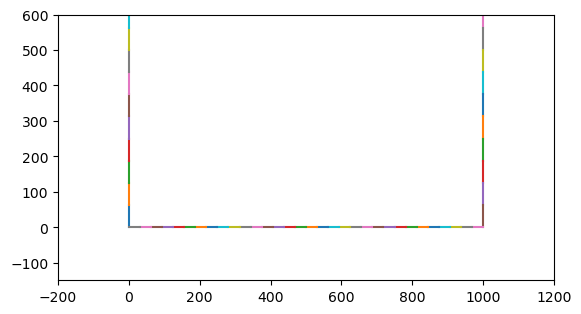

In [2]:
T = 8.   # [s]
f = 1/T
d = 40.  # [m]
c, cg, k = wave.wavec_interm(T, d)
print("wave length:", c/f)

region = Region.rectangle(1000, 2000, 32, 32)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 600])
ax.set_aspect('equal')

print("elements:", region.len())

The breakwater is closed, except from 400 to 600 at y=0. Where it is closed it is defined by:

$\frac{\partial \phi}{\partial n} = 0$

which, since it is defined on the derivative of the velocity potential is a Neumann boundary condition. Where it is open, $\phi$ and $\partial \phi$ is defined by the source.

In [34]:
bc = region.neumann_boundary_condition()


centers = region.centers()
normals = region.normals()



In the interior, there is no other incoming field.

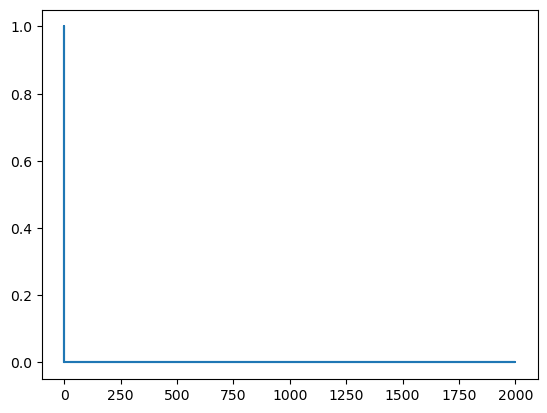

In [35]:
bi = region.boundary_incidence()

# Try to define incidence field
for i in range(region.len()):
    x = centers[i, :]
    n = normals[i, :]
    
    phi = source.plane(0, k, *x)[0]
    v = source.dplane(0, k, *x, -n)[0]
    
    # opening
    if x[1] < 0.1 and (x[0] >= 450. and x[0] <= 550.):    
        bc.beta[i] = 0.
        bc.alpha[i] = 1.

        bc.f[i] = phi
        #bi.phi[i] = phi
        #bi.v[i] = v
    else:
        #bc.beta[i] = 0
        #bc.alpha[i] = 0
        if x[1] < 0.1:
            #bc.f[i] = v
            #bc.beta[i] = 1.
            #bc.alpha[i] = 1.
            pass


        
plt.figure()
plt.plot(centers[:,1], np.abs(bc.f))

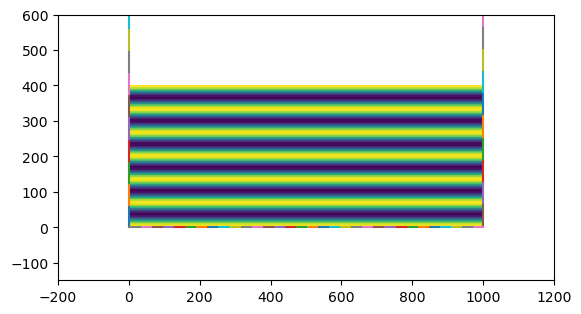

In [36]:
# Sample grid in the interior

x = np.arange(0.01, 999.1, 10)
y = np.arange(0.01, 599.1, 10)
xx, yy = np.meshgrid(x, y)


# Incident field without break-water
fI = source.plane(0, k, xx, yy)

f, ax = plt.subplots()
region.plot(ax)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 600])
ax.set_aspect('equal')
ax.imshow(fI.real, origin='lower', extent=[0, 1000, 0, 400])

In [37]:
# Solve boundary.

solver = Solver(region)
boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)

/tmp/ipykernel_316028/4066350755.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boundary_solution = solver.solve_boundary(Orientation.Interior, k, c, bc, bi)


In [38]:
# Solve samples in interior
#x = np.arange(0, 200, 2)
#y = np.arange(0, 200, 2)
#xx, yy = np.meshgrid(x, y)
ep = np.vstack((xx.ravel(), yy.ravel())).T

print('Solving for interior points:', ep.shape)
eF = boundary_solution.solve_samples(np.zeros(ep.shape[0]), ep)

Solving for interior points: (6000, 2)


Text(0.5, 1.0, 'Breakwater (single slit) $\\Re\\{\\phi\\}$')

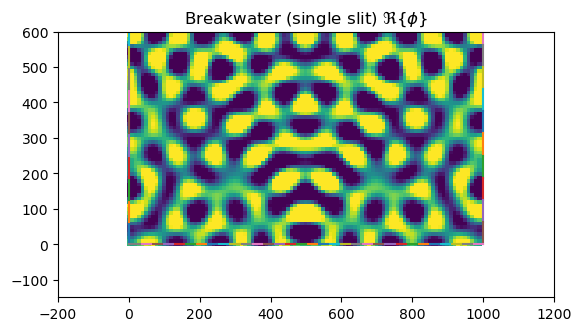

In [39]:
eFp = eF.phis.reshape(xx.shape)
f, ax = plt.subplots()
region.plot(ax)
ax.set_aspect('equal')
ax.pcolor(xx, yy, eFp.real, vmin=-1, vmax=1)
ax.set_xlim([-200, 1200])
ax.set_ylim([-150, 600])
ax.set_title('Breakwater (single slit) $\\Re\\{\\phi\\}$')

In [40]:
f.savefig('figures/breakwater_closed_single_slit.png', dpi=250)